# Clustering tries

## Imports and preprocessing

In [1]:
import pandas as pd

import Reader
import LogKeysManager
import ParamsExtractor
import DataPreprocessor
import ReduceDim
import ClusterData
import OneClass

2024-05-28 08:52:31.869791: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 08:52:31.870465: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 08:52:31.875796: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 08:52:31.927517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 08:52:32.738226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
# Testing Params Extractor
#log_types = ['cron', 'user']
log_types = ['cron', 'laurel', 'maillog', 'messages', 'secure', 'user']
file_paths = ['../../../temp_logs/login01.' + logtype + '.log' for logtype in log_types]

df_list = []

for file_path in file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file()
    df_list.append(df)

In [3]:
df_after = []

for i, df in enumerate(df_list):
    p = ParamsExtractor.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    df_after.append(new_df)

for i in range(len(df_list)):
    #print('=================')
    #print(df_list[i].head())
    #print(df_list[i].columns)
    #print(df_list[i].iloc[0])
    #print('********')
    #print(df_after[i].head())
    #print(df_after[i].columns)
    #print(df_after[i].iloc[0])
    
    # Concatenate df and df_after
    df_list[i] = pd.concat([df_list[i], df_after[i]], axis=1)
    #print(df_list[i].columns)

In [4]:
# Data Preprcessor

for i, df in enumerate(df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_one_hot_encode()
    df_list[i] = enc

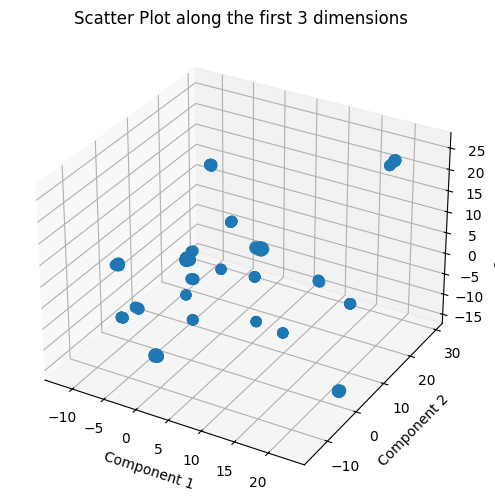

In [5]:
r = ReduceDim.ReduceDim(3, df_list[0], [1, 0])
umap_reduced_data = r.umap()

## Clustering

### dbscan

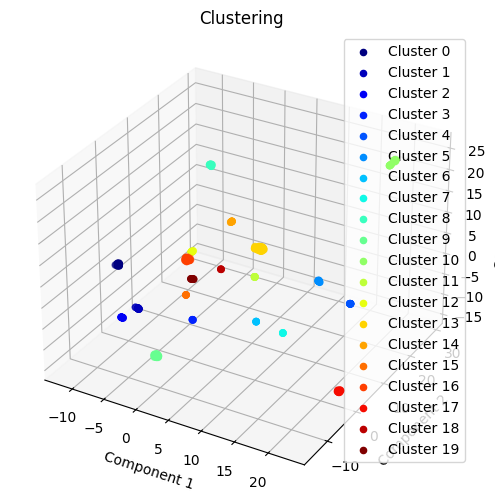

In [6]:
c = ClusterData.ClusterData(umap_reduced_data, plots=[1,0])
labels = c.dbscan()

### K-Means and K-Medoids

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [8]:
def k_means(data, num_clusters, random_state=42):
    """
    Perform K-means clustering on the input data.

    Parameters:
    - data: Input data (array-like or pandas DataFrame).
    - num_clusters: Number of clusters to create.
    - random_state: Random state for reproducibility.

    Returns:
    - kmeans_labels: Cluster labels assigned by K-means.
    - kmeans_centers: Coordinates of cluster centers.
    - inertia: Sum of squared distances of samples to their closest cluster center.
    """
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
    kmeans.fit(data)
    kmeans_labels = kmeans.labels_
    kmeans_centers = kmeans.cluster_centers_
    inertia = kmeans.inertia_

    return kmeans_labels, kmeans_centers, inertia

def optimize_k_means(data, max_clusters=10):
    """
    Optimize the number of clusters for K-means using the elbow method.

    Parameters:
    - data: Input data (array-like or pandas DataFrame).
    - max_clusters: Maximum number of clusters to test.

    Returns:
    - optimal_clusters: Optimal number of clusters determined by the elbow method.
    - elbow_plot: Matplotlib figure showing the elbow plot.
    """
    inertias = []
    cluster_range = range(1, max_clusters + 1)

    for num_clusters in cluster_range:
        _, _, inertia = k_means(data, num_clusters)
        inertias.append(inertia)

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, inertias, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

    # Determine the elbow point
    elbow_point = np.diff(inertias, 2).argmin() + 2  # +2 because the diff reduces the index by 2

    return elbow_point

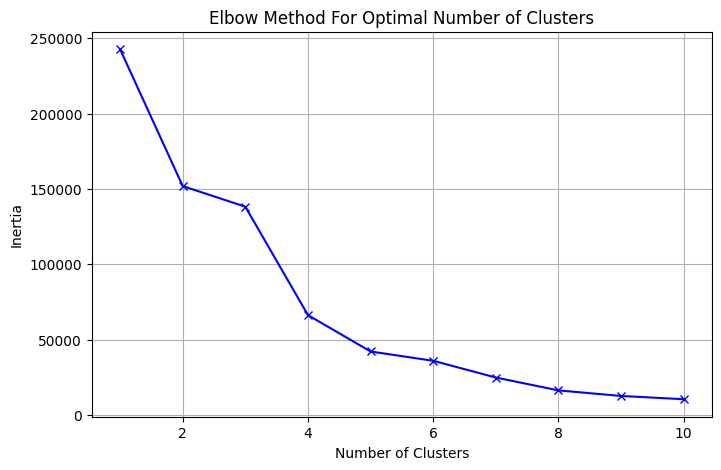

Optimal number of clusters: 3


In [9]:
data = umap_reduced_data
# Find the optimal number of clusters using the elbow method
optimal_clusters = optimize_k_means(data)

print("Optimal number of clusters:", optimal_clusters)

# Perform K-means with the optimal number of clusters
kmeans_labels, kmeans_centers, _ = k_means(data, optimal_clusters)

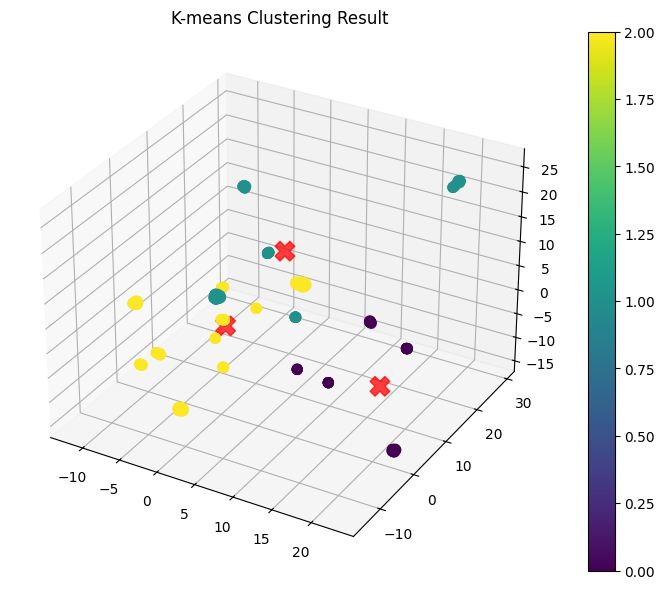

In [10]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=kmeans_labels, s=50, cmap='viridis')
ax.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], kmeans_centers[:, 2], s=200, c='red', alpha=0.75, marker='X')
ax.set_title('K-means Clustering Result')
plt.colorbar(sc)
plt.show()

Optimal number of clusters: 3


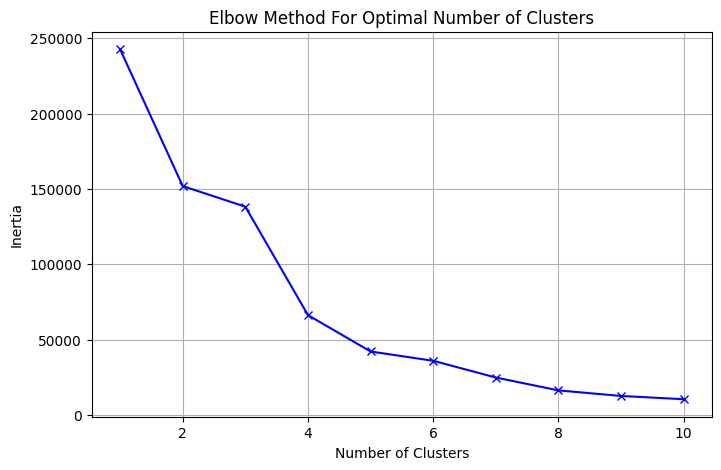

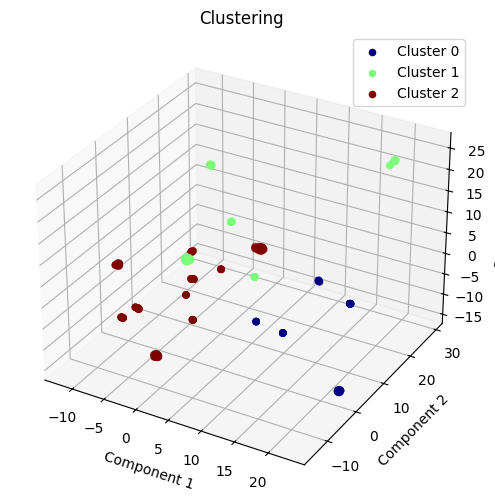

In [11]:
c = ClusterData.ClusterData(umap_reduced_data, plots=[1,1])
labels = c.k_means()

Optimal number of clusters: 8


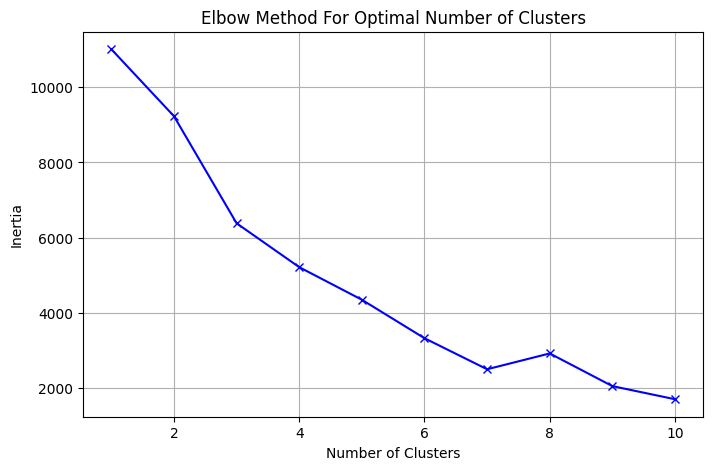

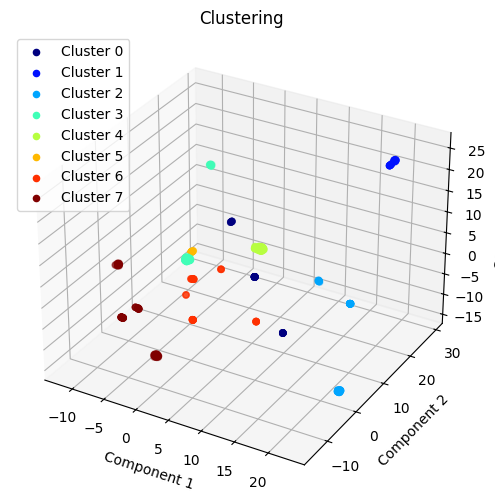

In [12]:
labels = c.k_medoids()

### OPTICS

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

In [14]:
'''
def optics_clustering(data, min_samples, xi, min_cluster_size):
    """
    Perform OPTICS clustering on the input data.

    Parameters:
    - data: Input data (array-like or pandas DataFrame).
    - min_samples: The number of samples in a neighborhood for a data point to be considered as a core point.
    - xi: Determines the minimum steepness of the cluster hierarchy. Smaller values result in finer cluster hierarchies.
    - min_cluster_size: Minimum number of samples in a cluster.

    Returns:
    - optics_labels: Cluster labels assigned by OPTICS.
    """
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    optics.fit(data)
    optics_labels = optics.labels_

    return optics_labels

def optimize_optics(data, min_samples_range, xi_range, min_cluster_size_range):
    """
    Optimize OPTICS clustering parameters based on silhouette score.

    Parameters:
    - data: Input data (array-like or pandas DataFrame).
    - min_samples_range: Range of min_samples to test.
    - xi_range: Range of xi values to test.
    - min_cluster_size_range: Range of min_cluster_size values to test.

    Returns:
    - best_params: Best parameters found.
    - best_score: Best silhouette score.
    """
    best_score = -1  # Initialize with a low value
    best_params = {}

    for min_samples in min_samples_range:
        for xi in xi_range:
            for min_cluster_size in min_cluster_size_range:
                labels = optics_clustering(data, min_samples, xi, min_cluster_size)
                n_labels = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise label -1

                if 1 < n_labels < len(labels):  # Ensure more than one cluster is formed
                    score = silhouette_score(data, labels)
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'min_samples': min_samples,
                            'xi': xi,
                            'min_cluster_size': min_cluster_size
                        }

    return best_params, best_score

# Example usage with sample data
from sklearn.datasets import make_blobs

# Generate sample data
data, _ = make_blobs(n_samples=300, centers=4, n_features=3, cluster_std=0.60, random_state=42)

# Define parameter ranges for optimization
min_samples_range = range(2, 10)
xi_range = np.linspace(0.01, 0.1, 10)
min_cluster_size_range = np.linspace(0.05, 0.2, 4)

# Find the optimal parameters using the defined ranges
best_params, best_score = optimize_optics(data, min_samples_range, xi_range, min_cluster_size_range)

print("Best parameters:", best_params)
print("Best silhouette score:", best_score)

# Perform OPTICS with the best parameters
optics_labels = optics_clustering(data, best_params['min_samples'], best_params['xi'], best_params['min_cluster_size'])

# Plotting the final clustering result in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=optics_labels, s=50, cmap='viridis')
ax.set_title('OPTICS Clustering Result')
plt.colorbar(sc)
plt.show()
'''

'\ndef optics_clustering(data, min_samples, xi, min_cluster_size):\n    """\n    Perform OPTICS clustering on the input data.\n\n    Parameters:\n    - data: Input data (array-like or pandas DataFrame).\n    - min_samples: The number of samples in a neighborhood for a data point to be considered as a core point.\n    - xi: Determines the minimum steepness of the cluster hierarchy. Smaller values result in finer cluster hierarchies.\n    - min_cluster_size: Minimum number of samples in a cluster.\n\n    Returns:\n    - optics_labels: Cluster labels assigned by OPTICS.\n    """\n    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)\n    optics.fit(data)\n    optics_labels = optics.labels_\n\n    return optics_labels\n\ndef optimize_optics(data, min_samples_range, xi_range, min_cluster_size_range):\n    """\n    Optimize OPTICS clustering parameters based on silhouette score.\n\n    Parameters:\n    - data: Input data (array-like or pandas DataFrame).\n   

In [15]:
'''
labels = c.optics()
'''

'\nlabels = c.optics()\n'

### Hierarchical Clustering

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

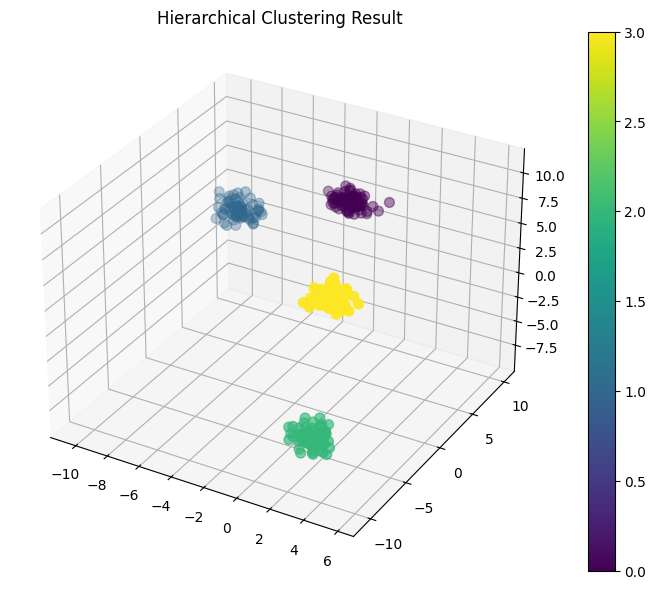

In [17]:
class HierarchicalClusteringOptimizer:
    def __init__(self, data, plots=[True]):
        self.data = data
        self.plots = plots
    
    def hierarchical_clustering(self, n_clusters):
        """
        Perform hierarchical clustering on the input data.

        Parameters:
        - n_clusters: Number of clusters to create.

        Returns:
        - labels: Cluster labels assigned by hierarchical clustering.
        """
        clustering = AgglomerativeClustering(n_clusters=n_clusters)
        labels = clustering.fit_predict(self.data)
        return labels

    def optimize_hierarchical(self, max_clusters=10):
        """
        Optimize the number of clusters for hierarchical clustering using the silhouette score.

        Parameters:
        - max_clusters: Maximum number of clusters to test.

        Returns:
        - best_n_clusters: Best number of clusters.
        - best_score: Best silhouette score.
        """
        best_score = -1  # Initialize with a low value
        best_n_clusters = 2  # Minimum number of clusters to test

        for n_clusters in range(2, max_clusters + 1):
            labels = self.hierarchical_clustering(n_clusters)
            score = silhouette_score(self.data, labels)
            if score > best_score:
                best_score = score
                best_n_clusters = n_clusters

        return best_n_clusters, best_score

    def perform_hierarchical_clustering(self):
        """
        Perform hierarchical clustering on the input data with optimized number of clusters.

        Returns:
        - labels: Cluster labels assigned by hierarchical clustering.
        """
        best_n_clusters, best_score = self.optimize_hierarchical()

        # Perform hierarchical clustering with the best number of clusters
        labels = self.hierarchical_clustering(best_n_clusters)

        # Plotting results if required
        if self.plots[0]:
            self.visualize(labels)
        
        return labels

    def visualize(self, labels):
        """
        Visualize the clustering result in 3D.

        Parameters:
        - labels: Cluster labels to visualize.
        """
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(self.data[:, 0], self.data[:, 1], self.data[:, 2], c=labels, s=50, cmap='viridis')
        ax.set_title('Hierarchical Clustering Result')
        plt.colorbar(sc)
        plt.show()

# Example usage with sample data
from sklearn.datasets import make_blobs

# Generate sample data
data, _ = make_blobs(n_samples=300, centers=4, n_features=3, cluster_std=0.60, random_state=42)

# Create an instance of the optimizer
optimizer = HierarchicalClusteringOptimizer(data)

# Perform hierarchical clustering with optimized parameters
labels = optimizer.perform_hierarchical_clustering()


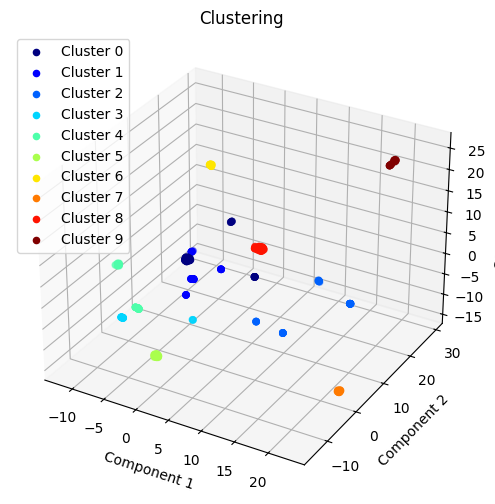

In [18]:
labels = c.hierarchical()

### SOM

In [19]:
labels = c.som()

KeyboardInterrupt: 

### Hopkins Statistics

H ≈ 1: The dataset has a high tendency to cluster. This indicates that the dataset contains meaningful clusters.

H ≈ 0.5: The dataset is uniformly distributed, indicating no meaningful clusters.

H ≈ 0: This value is rare and would suggest highly anomalous data or errors in computation.

In [21]:
H = c.hopkins()

Hopkins statistic: 0.9926856983453977


NB. Very long optimization of hyperparameters

H ≈ 1: The dataset has a high tendency to cluster. This indicates that the dataset contains meaningful clusters.

H ≈ 0.5: The dataset is uniformly distributed, indicating no meaningful clusters.

H ≈ 0: This value is rare and would suggest highly anomalous data or errors in computation.

In [20]:
H = c.hopkins()

Hopkins statistic: 0.9926856983453977


### other